In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.base import BaseEstimator, TransformerMixin

## Prepare

In [14]:
df = pd.read_csv('./mobil_listrik.csv')

In [17]:
df.head()

,id_komentar,nama_akun,tanggal,tweet,label
0,Ugzbll5eyrIy3-gdUUJ4AaABAg,Sqn Ldr,2023-08-06 12:54:49+00:00,saran sih bikin harga ionic sama kayak brio ...,positif
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif


## Preprocess

In [16]:
# rename column text_clean to tweet
df.rename(columns={'text_cleaning': 'tweet'}, inplace=True)
df.rename(columns={'sentimen': 'label'}, inplace=True)

In [18]:
# remove blank 
df = df[df['tweet'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1515 entries, 0 to 1516
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_komentar  1515 non-null   object
 1   nama_akun    1514 non-null   object
 2   tanggal      1515 non-null   object
 3   tweet        1515 non-null   object
 4   label        1515 non-null   object
dtypes: object(5)
memory usage: 71.0+ KB


In [19]:
# Remove non ngetif or positif label
df = df[(df.label == 'positif') | (df.label == 'negatif')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1373 entries, 0 to 1516
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_komentar  1373 non-null   object
 1   nama_akun    1372 non-null   object
 2   tanggal      1373 non-null   object
 3   tweet        1373 non-null   object
 4   label        1373 non-null   object
dtypes: object(5)
memory usage: 64.4+ KB


In [20]:
def regexOperation(tweet):
    # Remove Non-ascii
    res = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    # Remove url
    res = re.sub(r'http[s]?\:\/\/.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', res)
    res = re.sub(r'pic.twitter.com?.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', res)
    # Remove mention
    res = re.sub(r'\@([\w]+)',' ', res)
    
    # Remove hashtag
    # res = re.sub(r'\#([\w]+)',' ', res)
    # Proccessing hashtag (split camel case)   
    res = re.sub(r'((?<=[a-z])[A-Z]|[A-Z](?=[a-z]))', ' \\1', res)
    #res = re.sub(r'([A-Z])(?<=[a-z]\1|[A-Za-z]\1(?=[a-z]))',' \\1', res)
    
    
    # Remove special character
    res = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', res)
    # Remove number
    res = re.sub(r'[0-9]+','', res)
    # Remove consecutive alphabetic characters
    res = re.sub(r'([a-zA-Z])\1\1','\\1', res)
    # Remove consecutive whitespace
    res = re.sub(' +', ' ', res)
    # Remove trailing and leading whitespace
    res = re.sub(r'^[ ]|[ ]$','', res)
    
    # Convert to lower case
    res = res.lower()

    return res

In [21]:
# Tokenization using NLTK

def tokenize(tweet):
    return word_tokenize(tweet)


In [22]:
# Stopwords removal
stopwordFactory = StopWordRemoverFactory()

stopwords = stopwordFactory.get_stop_words()

def remove_stopwords(tweet):
    return [word for word in tweet if word not in stopwords]


In [23]:
# Stemming using Sastrawi
stemmerFactory = StemmerFactory()

stemmer = stemmerFactory.create_stemmer()

def stemming(tweet):
    return [stemmer.stem(word) for word in tweet]


In [24]:
# Apply all preprocessing step except Vectorization
def preprocess(tweet):
    tweet = regexOperation(tweet)
    tweet = tokenize(tweet)
    tweet = remove_stopwords(tweet)
    tweet = stemming(tweet)
    tweet = ' '.join(tweet)
    return tweet

df['tweet'] = df['tweet'].apply(preprocess)
df.head()

,id_komentar,nama_akun,tanggal,tweet,label
0,Ugzbll5eyrIy3-gdUUJ4AaABAg,Sqn Ldr,2023-08-06 12:54:49+00:00,saran sih bikin harga ionic sama kayak brio in...,positif
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya rumah bl...,negatif


In [25]:
# Vectorization with TF-IDF
vectorizer = TfidfVectorizer(
    analyzer='word',
    max_features=1000,
    ngram_range=(1, 1)
    )

## ML

In [26]:
# # Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [27]:
# Encoding label
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [28]:
# K-Fold Cross Validation for Hyperparameter Tuning
kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [29]:
# Train SVM model
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1], 'svc__gamma': [1,0.1,0.01,0.001],'svc__kernel': ['rbf', 'poly', 'sigmoid']}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(x_train, y_train_encoded)
grid_svm.score(x_test, y_test_encoded)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


0.9131671787868443

In [30]:
print(grid_svm.best_params_)

{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'sigmoid'}


## Evaluation

In [31]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)

    cf_matrix = confusion_matrix(y, pred)
    group_names = ["TN","FP","FN","TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=plt.cm.copper)

    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result


{'auc': 0.9131671787868443,
 'f1': 0.7570093457943925,
 'acc': 0.8109090909090909,
 'precision': 0.7168141592920354,
 'recall': 0.801980198019802}

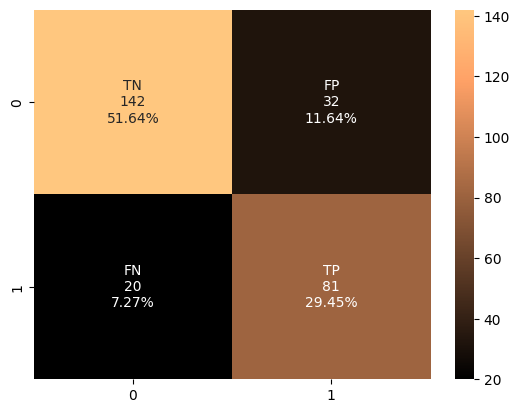

In [32]:
report_results(grid_svm.best_estimator_, x_test, y_test_encoded)

In [33]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [34]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, x_test, y_test_encoded)

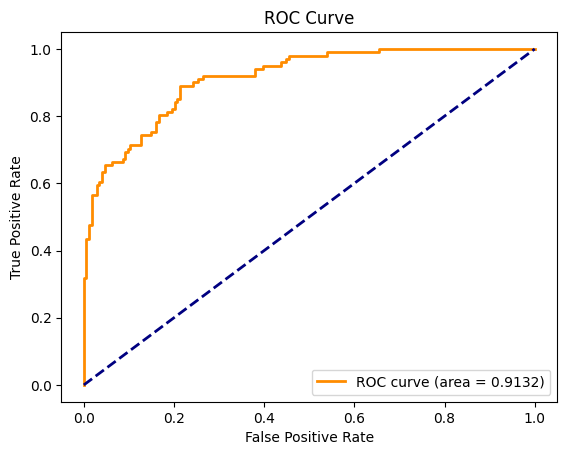

In [35]:
fpr, tpr = roc_svm
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Test on new data

In [36]:
new_tweets = [
    'seharusnya masyarakat harus lebih diberikan pemahaman tentang mobil listrik, karena mobil listrik ini sangat ramah lingkungan. Ayo kita dukung mobil listrik',
    'kebijakan insentif mobil listrik ini sangat bagus, karena mobil listrik ini sangat ramah lingkungan. Ayo kita dukung mobil listrik',
    'kebijakn ini sangat membuang buang uang negara, mobil listrik ini tidak akan laku di indonesia',
    'mobil listrik tidak cocok untuk indonesia, karena jarak tempuhnya yang pendek',
]
le.inverse_transform(grid_svm.best_estimator_.predict([preprocess(tweet) for tweet in new_tweets]))

array(['positif', 'positif', 'negatif', 'positif'], dtype=object)